
# **ECSE  415 Assignment 2**
#Melis Malki - 260775809
##October 19, 2020

##**Initialization**

In [172]:
!pip install opencv-python==3.3.0.10 
!pip install opencv-contrib-python==3.3.0.10 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**1 Invariance of SIFT Features**




###Invariance Under Changes in Scale

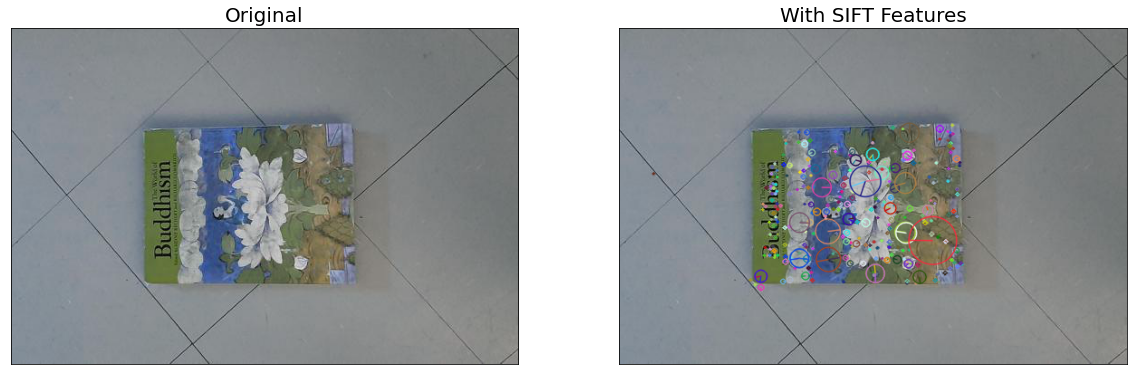

In [173]:
# Read the "book.jpg"
book = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_2/book.jpg')

# Copy Image
book_copy = book.copy()

#Convert to RGB
book = cv2.cvtColor(book, cv2.COLOR_BGR2RGB)
book_copy = cv2.cvtColor(book_copy, cv2.COLOR_BGR2RGB)

#Create SWIFT Object
sift = cv2.xfeatures2d.SIFT_create()

#Detect keypoints without marks
keypoints= sift.detect(book, None)

#Draw the keypoints
cv2.drawKeypoints(book, keypoints, book_copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(book)
plt.title("Original", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(book_copy)
plt.title("With SIFT Features", fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()



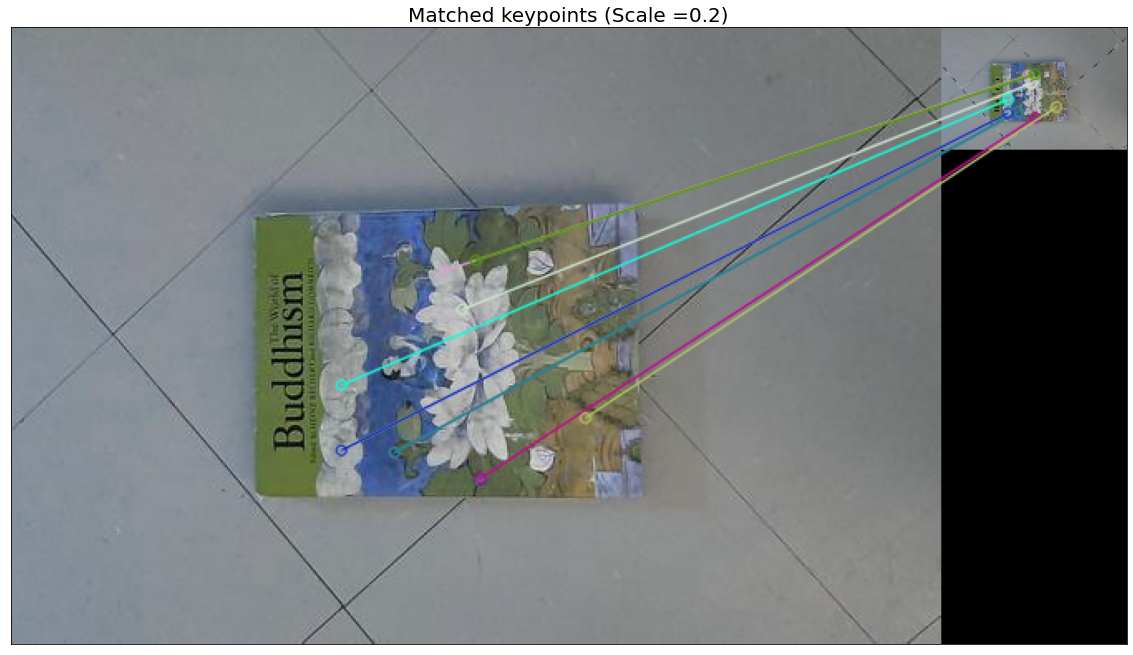

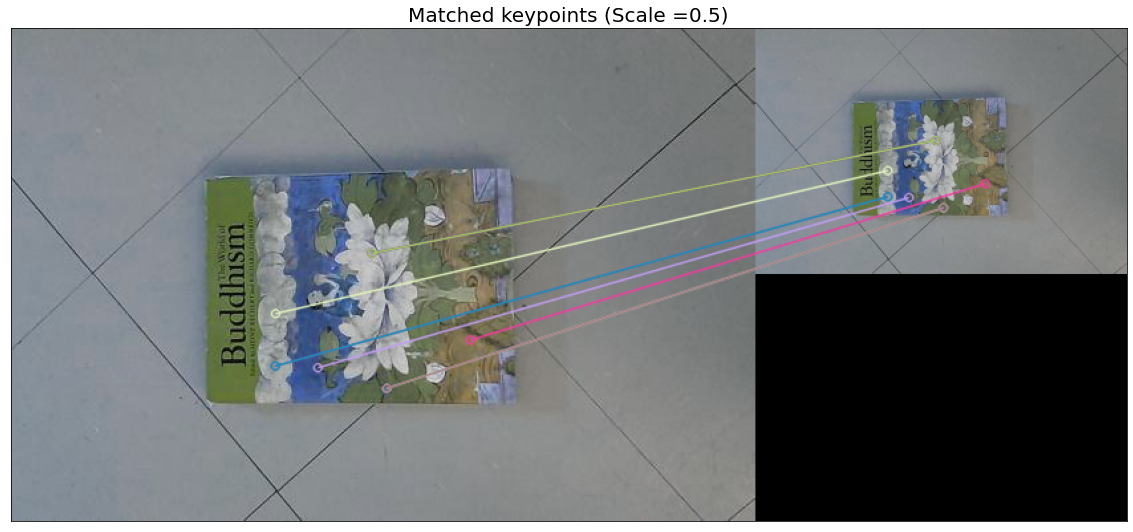

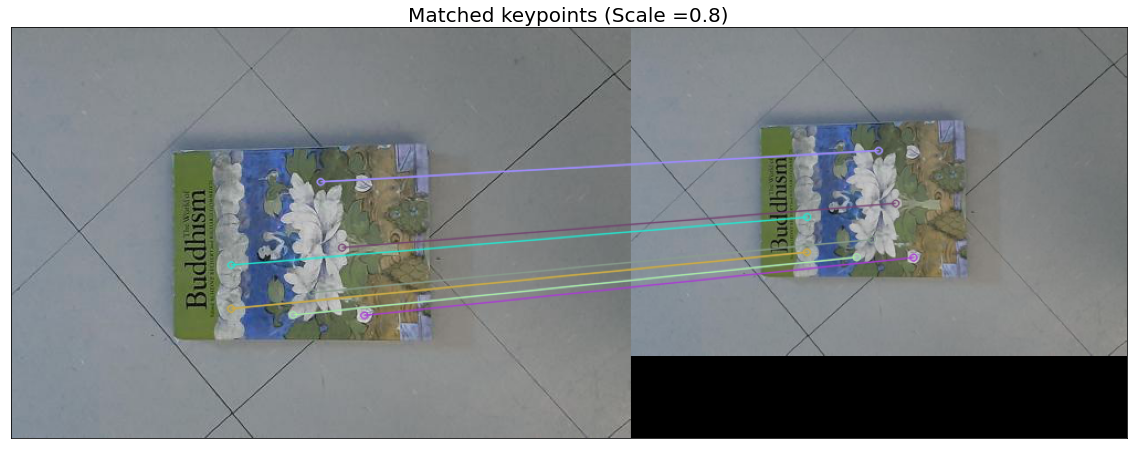

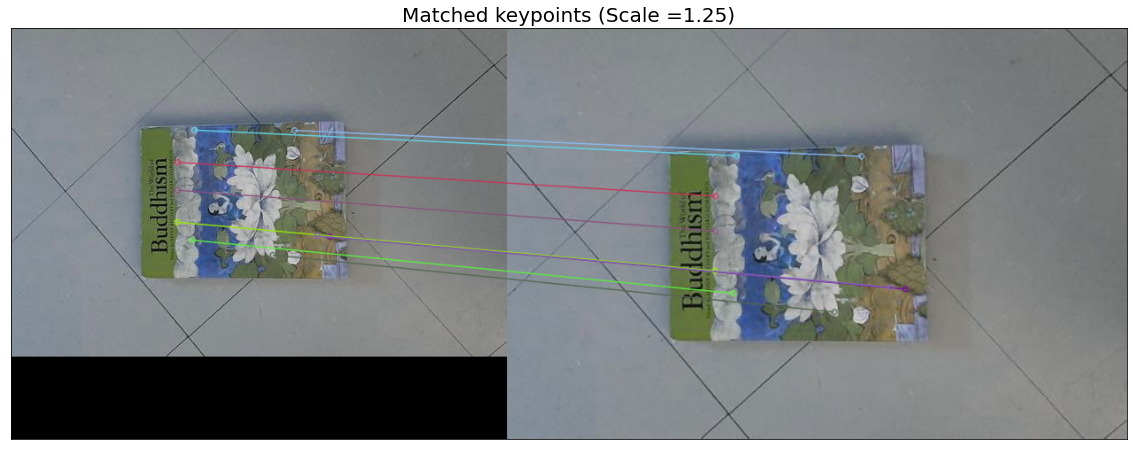

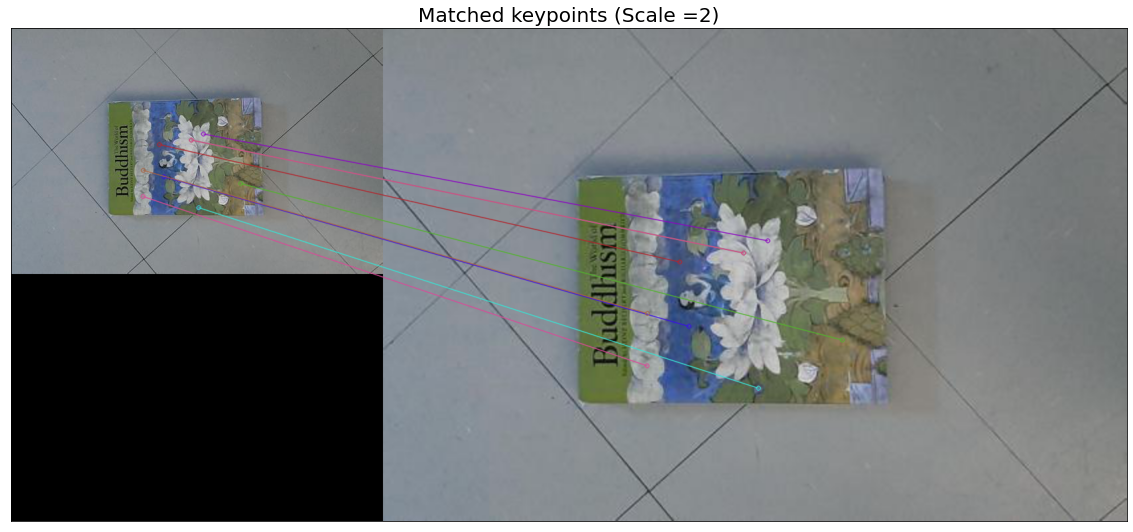

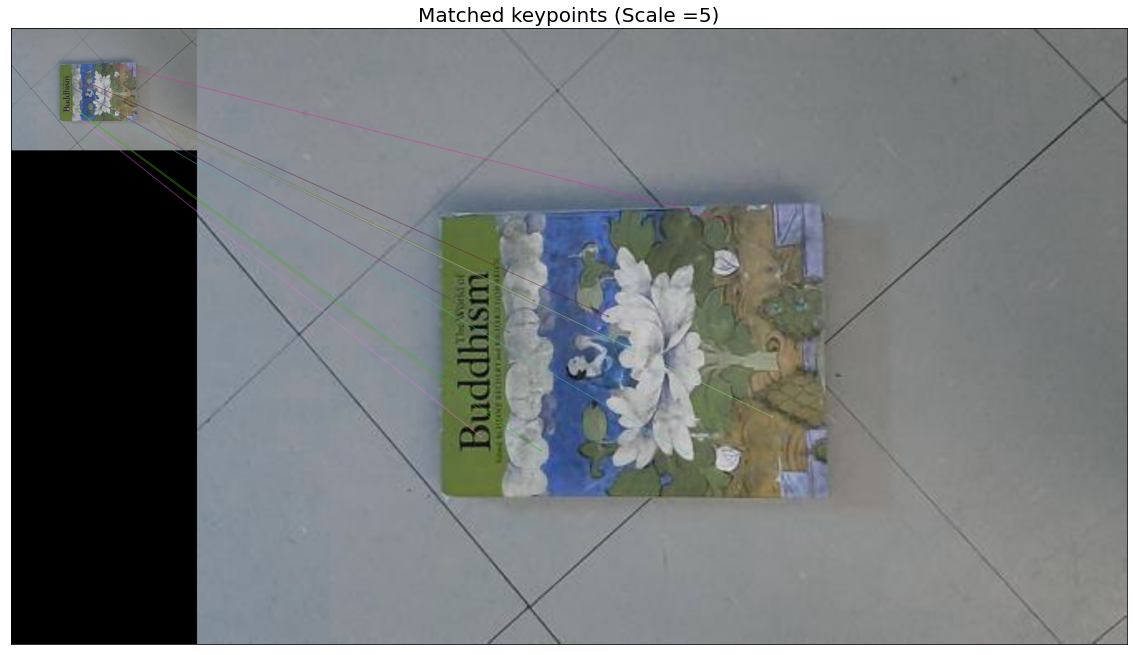

In [174]:
#Scales
scales = [0.2,0.5,0.8,1.25,2,5]

matchList = dict()

#create BFMatcher
bf = cv2.BFMatcher()

keypoints_initial,descriptors_initial = sift.detectAndCompute(book,None)

for scale in scales:
  book_scaled = cv2.resize(book,None,fx=scale,fy=scale)
  keypoints_scaled,descriptors_scaled = sift.detectAndCompute(book_scaled, None)
  #Match key points
  matchList[scale] = bf.match(descriptors_initial,descriptors_scaled)
  
  #Sort matching keypoints
  matchList[scale]= sorted(matchList[scale], key = lambda x:x.distance)

  #Display top tenmatched key points
  book_matched = cv2.drawMatches(book,keypoints_initial,book_scaled,keypoints_scaled, matchList[scale][:10], None, flags=2)

  plt.figure(figsize=(20,20))
  plt.imshow(book_matched)
  plt.title(f"Matched keypoints (Scale ={scale})", fontsize = 20), plt.xticks([]), plt.yticks([])
  plt.show()


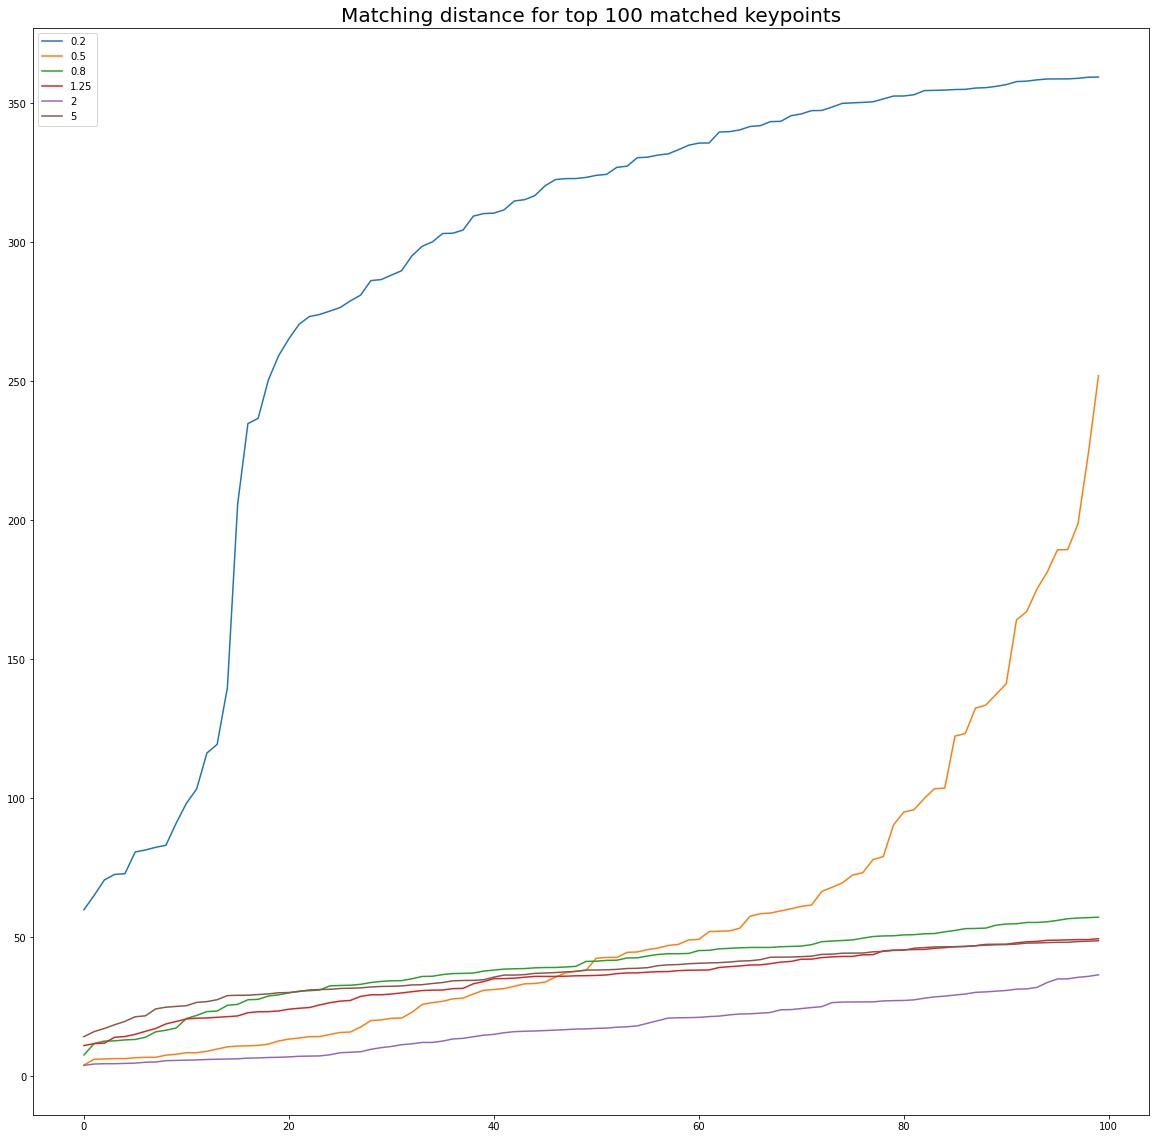

In [175]:
plt.figure(figsize=(20,20))
plt.title("Matching distance for top 100 matched keypoints", fontsize=20)
for scale in scales:
  plt.plot([m.distance for m in matchList[scale][:100]], label = scale)
plt.legend()
plt.show()

The matching distance and scale are inversely proportional. The matching distance decreases as the scale increases. The matching distance gets more optimal when it is lower because it means that there are more pixels to analyze for more accurate matching. The most significant change in the matching distance occurs when the scale increases from 0.2 to 0.8. The matching distance values ramps up exponentially for the scales 0.2 and 0.5. The least significant difference in the matching distance occurs when the scale increases from 2 to 5. This shows that matching distances are getting not optimal as the scale difference between the images increases.

###Invariance Under Rotation

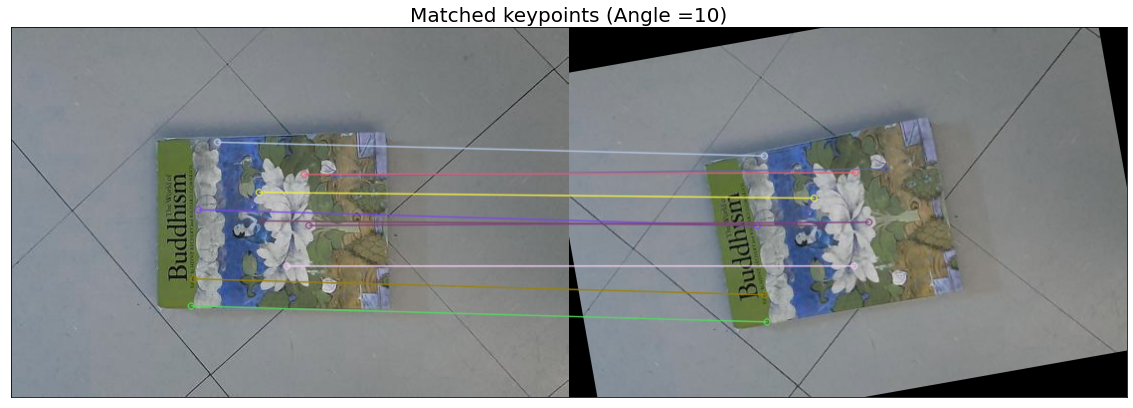

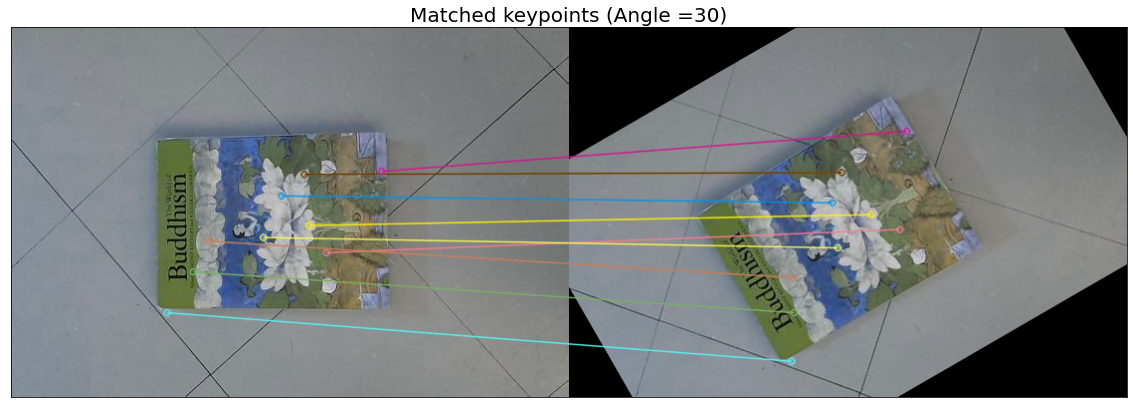

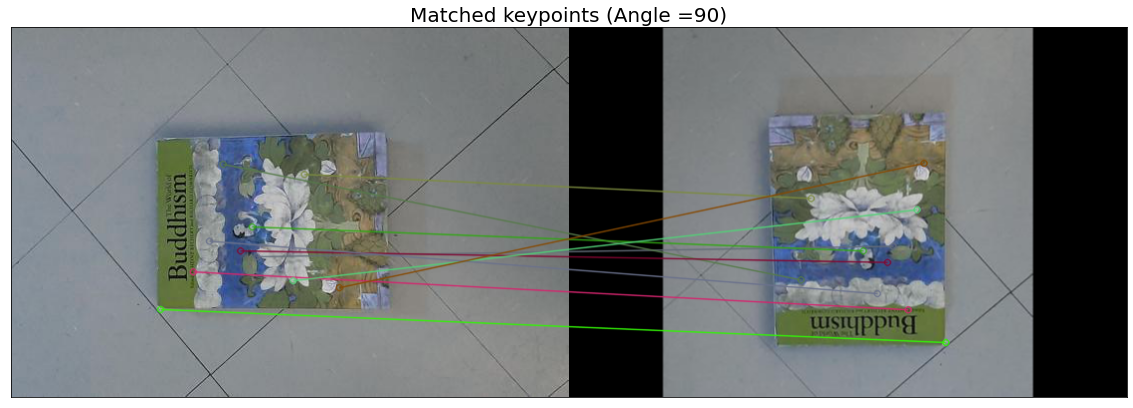

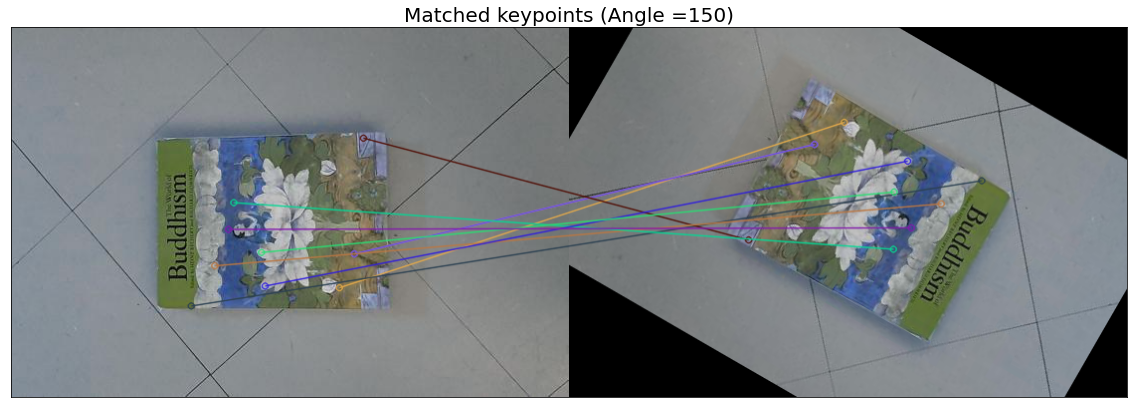

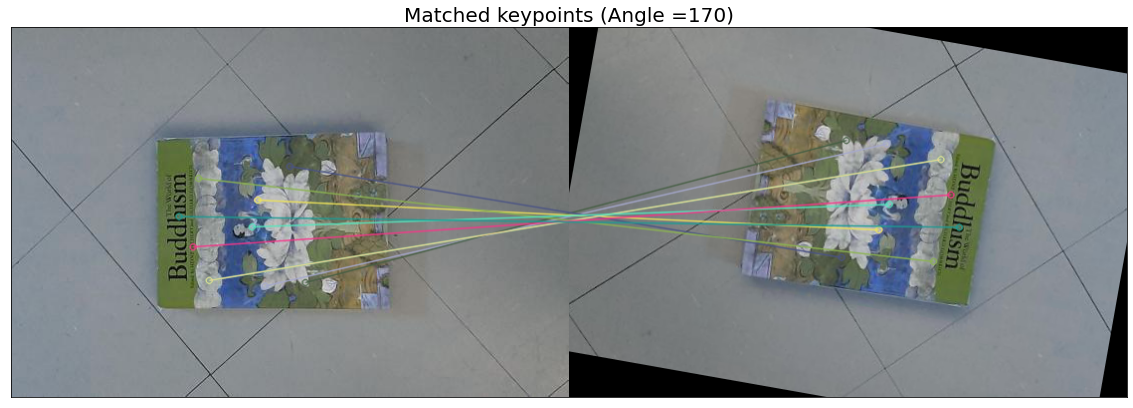

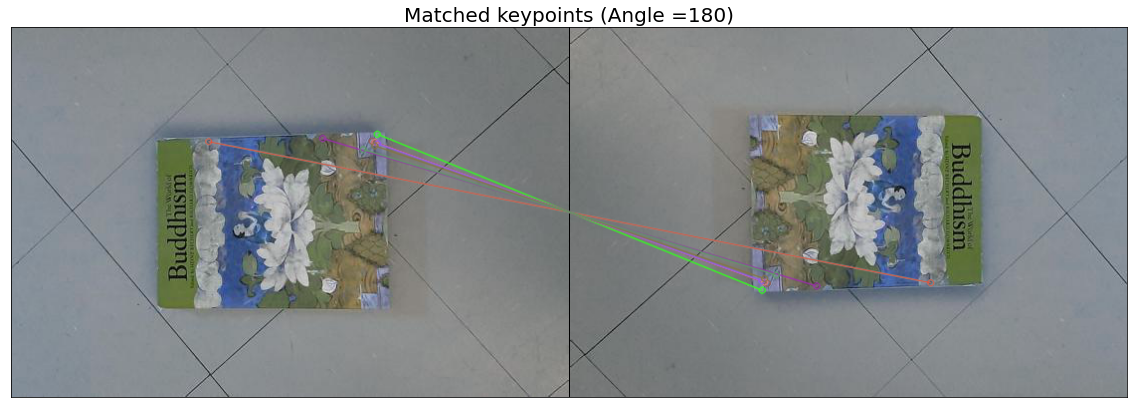

In [176]:
#Angles
angles = [10,30,90,150,170,180]

matchList = dict()

#Height and width
height, width = book.shape[0:2]

for angle in angles:
  #Rotation Matrix
  matrix = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
  
  #Apply Rotation
  book_rotated = cv2.warpAffine(book,matrix,(width,height))

  #Keypoint and description of original image is already defined in the previous sub section.
  keypoints_rotated,descriptors_rotated = sift.detectAndCompute(book_rotated, None)
  
  #BF Matcher is already created in the previous sub seciton.
  matchList[angle] = bf.match(descriptors_initial,descriptors_rotated)
  matchList[angle] = sorted(matchList[angle], key = lambda x:x.distance)

  book_rotated_matched = cv2.drawMatches(book,keypoints_initial,book_rotated,keypoints_rotated, matchList[angle][:10], None, flags=2)

  plt.figure(figsize=(20,20))
  plt.imshow(book_rotated_matched)
  plt.title(f"Matched keypoints (Angle ={angle})", fontsize = 20), plt.xticks([]), plt.yticks([])
  plt.show()

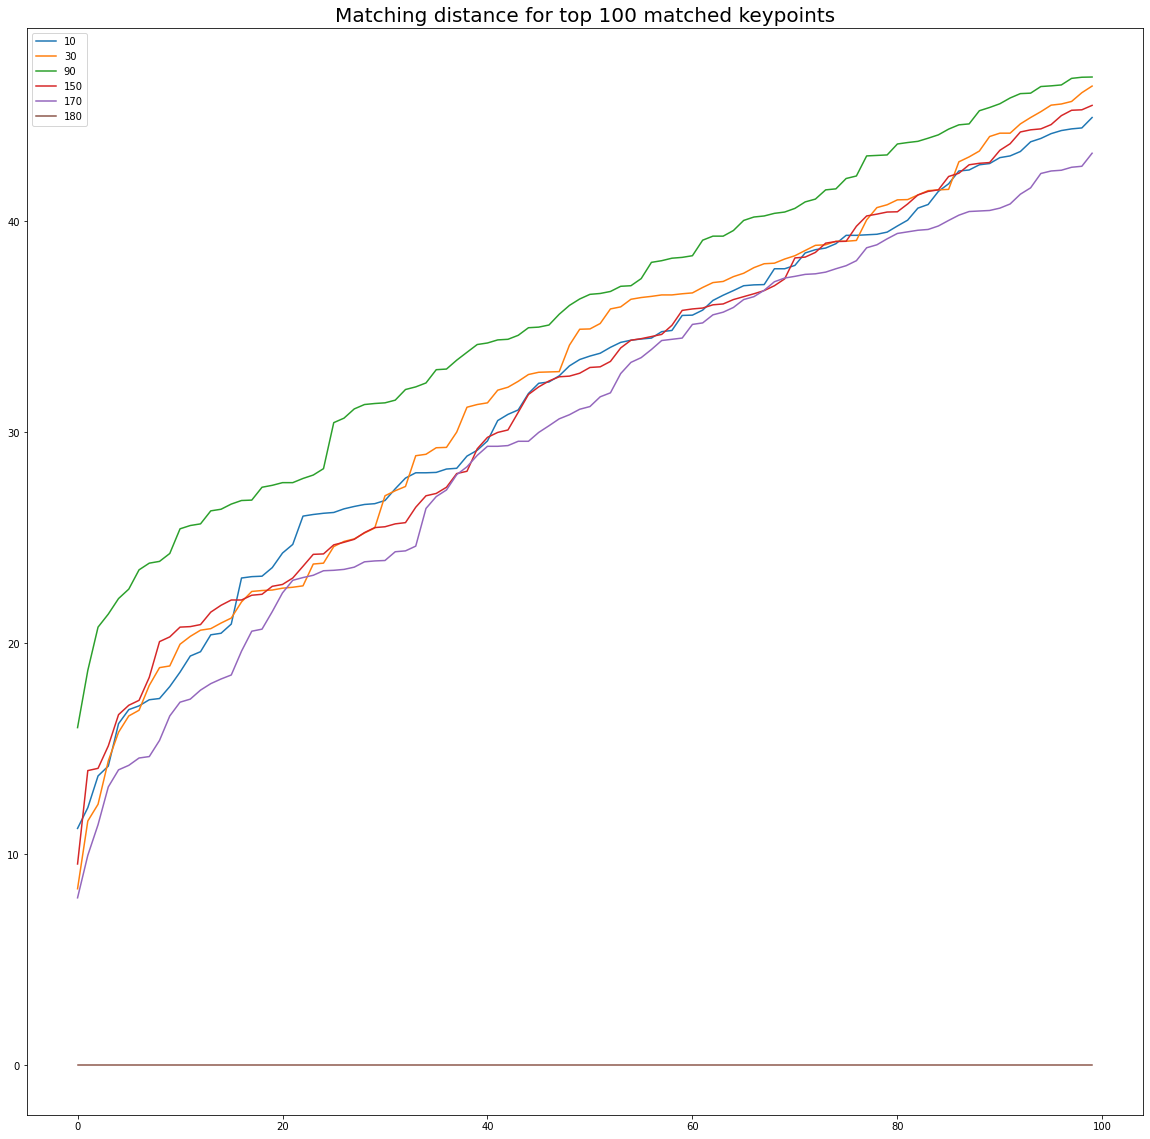

In [178]:
plt.figure(figsize=(20,20))
plt.title("Matching distance for top 100 matched keypoints", fontsize=20)
for angle in angles:
  plt.plot([m.distance for m in matchList[angle][:100]], label = angle)
plt.legend()
plt.show()

The matching distance decreases as the rotate angle aligns more closely with the original image. Matching distances for all angles except 180 degrees shows similar trends. As the angle increases from 0 to 90 degrees, the matching distances slightly increase, and as the angles increases from 90 to 170 degrees, the matching distances slightly decrease. When the angle reaches 180 degrees, the matching distance is 0. The matching distance's behavior shows that matching distance is more improved as the rotated image aligns more with the original image. This because the orientation vector for both rotated and the original image gets more similar in this way.

##**2 Matching using SIFT - Book Reveal**




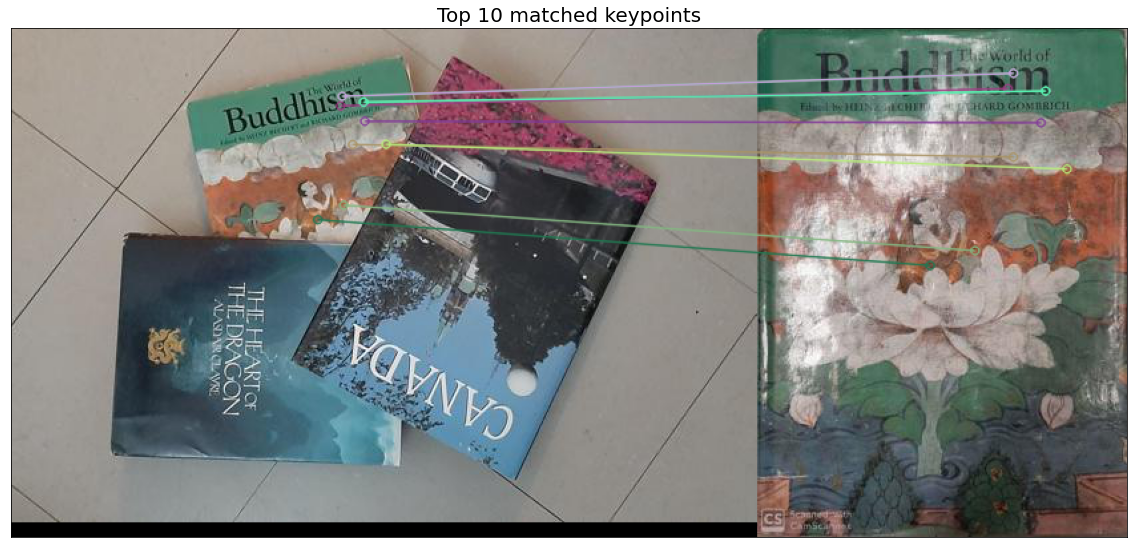

In [179]:
#Read Images
book_occlusion = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_2/book_occlusion.jpg')
book_crop = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_2/book_crop.jpg')

# Copy Image
book_occlusion_copy = book_occlusion.copy()
book_crop_copy = book_crop.copy()


#Detect SIFT feature
mask = np.zeros(book_occlusion.shape[:2], dtype=np.uint8)
cv2.rectangle(mask, (133,20), (310,160), (255), thickness=-1)
keypoints_occlusion, descriptors_occlusion = sift.detectAndCompute(book_occlusion, mask)
keypoints_crop, descriptors_crop = sift.detectAndCompute(book_crop, None)

#BF Matcher is already created in the previous sub seciton.
matches = bf.match(descriptors_occlusion,descriptors_crop)
matches = sorted(matches, key = lambda x:x.distance)

book_occlusion_matched = cv2.drawMatches(book_occlusion,keypoints_occlusion,book_crop,keypoints_crop, matches[:10], None, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(book_occlusion_matched)
plt.title("Top 10 matched keypoints", fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()


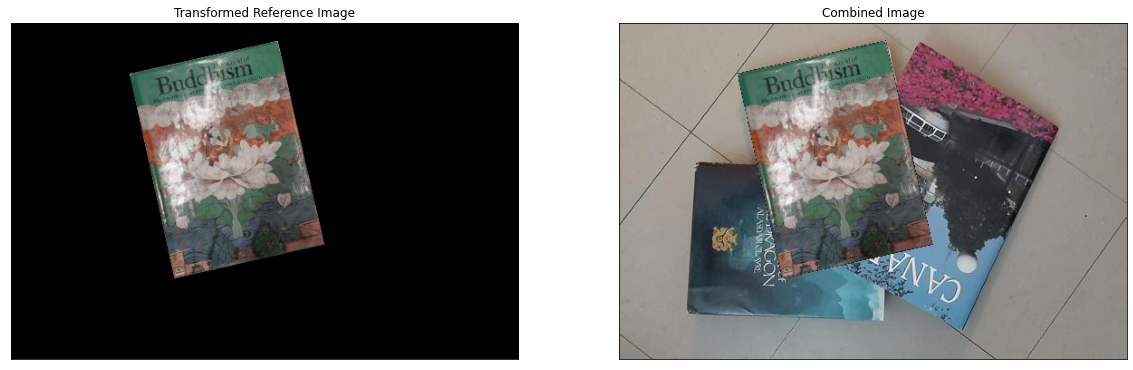

In [180]:
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mp_occlusion = np.float32([keypoints_occlusion[i].pt for (__, i) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (i, __) in GoodMatches])

# Homography using RANSAC
H, __ = cv2.findHomography(mp_crop, mp_occlusion, cv2.RANSAC)
warped_img = cv2.warpPerspective(book_crop, H, (book_crop.shape[1]+book_occlusion.shape[1], book_occlusion.shape[0]))

# Crop extra space
warped_img = warped_img[:,:book_occlusion.shape[1],:]

#Display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(warped_img)
plt.title("Transformed Reference Image"), plt.xticks([]), plt.yticks([])

# If pixel is not black change it in occlusion picture
combined_img = book_occlusion.copy()
for x in range(combined_img.shape[0]):
  for y in range(combined_img.shape[1]):
    for z in range(combined_img.shape[2]):
      if warped_img[x,y,z] > 0:
        combined_img[x,y,z] = warped_img[x,y,z]

plt.subplot(122), plt.imshow(combined_img)
plt.title("Combined Image"), plt.xticks([]), plt.yticks([])
plt.show()

##**3 Face Detection**




###Eigenface Representation


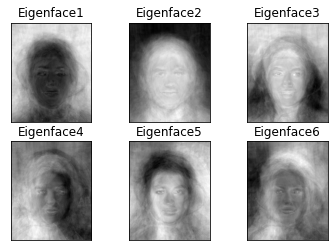

In [181]:
# number of Images = 100
# width = 178
# height = 218
def pca_train(numberOfImages,width,height):
  #1 Initialization
  train_images = np.zeros((numberOfImages, height, width),dtype='float64')

  #2 Loading Train Images
  for i in range(numberOfImages):
    image = mpimg.imread('/content/drive/My Drive/ECSE 415/Assignment_2/' + str(i+1) + ".jpg")
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    train_images[i] = gray
  ## train_image.shape =  (100,218,178)

  #3 Build Matrix of the dataset
  train_image_matrix = train_images.reshape(train_images.shape[0],(train_images.shape[1]*train_images.shape[2]))
  ## train_image_matrix.shape = (100, (218*178)) = (100,38804)

  #4 Transpose the matrix
  train_image_matrix_T = train_image_matrix.T
  ## train_image_matrix_T.shape = (38804,100)

  #5 Calculating Mean Face
  mean = np.mean(train_image_matrix_T,axis=1)
  ## mean.shape = (38804,) Need to reshape.
  mean = np.resize(mean, (mean.shape[0],1))
  mean = np.tile(mean, numberOfImages)
  ## mean.shape = (38804,100)

  #6 Mean - Image
  normalization = np.subtract(train_image_matrix_T,mean)
  ## normalization.shape = (38804,100)

  #7 Matrix Multiplication
  multiplication = np.matmul(train_image_matrix, train_image_matrix_T)
  ## multiplication.shape = (100,100)

  #8 Eigenvalues and Eigenvectors
  eigenvalues, eigenvectors, = np.linalg.eig(multiplication)

  #9 Sort in descending order
  x = eigenvalues.argsort()[::-1]
  eigenvalues = eigenvalues[x]
  eigenvectors = eigenvectors[:,x]

  #10 Eigenface
  eigenfaces = normalization.dot(eigenvectors)
  ## eigenfaces.shape = (38804,100)

  return train_image_matrix,mean,normalization,eigenfaces

#Display first 6 Eigenfaces
train_image_matrix,mean,normalization,eigenfaces = pca_train(100,178,218)
for i in range(6):
    img = eigenfaces[:,i].reshape(218,178)
    plt.subplot(2,3,1+i)
    plt.imshow(img, cmap='gray')
    plt.title("Eigenface" + str(i+1)), plt.xticks([]), plt.yticks([])

plt.show()

### PCA Face Detection


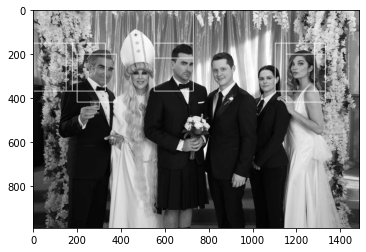

In [182]:
test_image = cv2.imread("/content/drive/My Drive/ECSE 415/Assignment_2/schitt's_creek_group_photo.jpeg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_copy = test_image.copy()

train_image_matrix,mean,normalization,eigenfaces = pca_train(numberOfImages=100,width= 178,height = 218)
train_weight = normalization.T.dot(eigenfaces)
#Sliding window 
for y in range(0, test_image.shape[0], 50):
    for x in range(0, test_image.shape[1], 50):
        (x,y,window) = (x, y, test_image[y:y + 218, x:x + 178])
        if window.shape[0] != 218 or window.shape[1] != 178:
          continue
        window_resized = np.resize(window, (218*178,1))
        #Test window properties
        test_normalized = np.subtract(window_resized, mean)
        test_weight = test_normalized.T.dot(eigenfaces)
        distance = np.linalg.norm(test_weight - train_weight, axis=1).mean()
        # Check the limits for the distance to mark faces
        ##lower threshold = 660000000
        ##upper threshold = 680000000
        if(distance>670000000):
          if(distance<680000000):
            cv2.rectangle(test_image, (x, y), (x + 178, y + 218), (255, 0, 0), 2)     
            
plt.imshow(test_image, cmap="gray")

This method is not working perfectly. Only 3 faces out of 6 faces can be successfully detected. There few false positive face detections these are flowers and curtain normally. This is can be because of the lightening.

### Viola-Jones detection

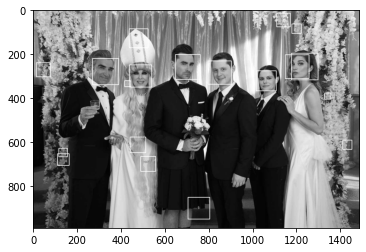

In [183]:
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/ECSE 415/Assignment_2/haarcascade_frontalface_default.xml')
test_image_gray = test_image_copy
faces = face_cascade.detectMultiScale(test_image_gray, 1.1, 2)
for (x,y,w,h) in faces:
    test_image_gray = cv2.rectangle(test_image_gray,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(test_image_gray, cmap="gray")
plt.show()

Viola-Jones method works better compared to PCA. It detects all of the faces. On the other hand, there is more false-positive face detection compared to PCA.

There are several reasons why Viola-Jones methods might work better than PCA: 
1.   PCA is worse at recognizing faces in different poses and lightening
2.   PCA is not good at recognizing emotion and expressions
3. PCA works better in an uniform background.